# Visualization of the trained model

In this notebook we will mainly visualize what's the model capable of. Additionally, we will also visualize some of its internal components as the data goes through them, such as the alpha scores or the features from the Encoder.

Let's first import the necessary libraries

## Imports

In [1]:
# Import of the model structure
from utils.utils import *
from models.models import *

# Data manipulation
import numpy as np
import torchvision.transforms as T

# Visualization
import matplotlib.pyplot as plt
from utils.visualizations import *

# Other useful libraries
import sys

C:\Users\donai\Anaconda3\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Loading the model

**Important**: Change the following paths to match the location where your data is stored. In the next cell I'm assuming that you have a folder named `logs` inside the folder `data` with the *trained* model. If you don't, simply execute the model and the `.pth` file will be automatically generated in the `logs` folder.

In [2]:
DATA_LOCATION = '../data'
model_path = DATA_LOCATION + '/logs/EncoderDecorder_model.pth'

We choose the hardware we are using to run this notebook.

In [3]:
device = 'cpu' # or 'cuda:0'

Finally, we load the model using the custom function `load_ED_model`. Make sure to indicate in the third arguement which Encoder you used to train the model you're loading. Otherwise the weights won't match and it will return an error.

In [4]:
model = load_ED_model(model_path, device, 'ResNet152')


## Visualizing the saved image and caption for a certain epoch

When the model is trained, an image and a caption is saved as a `.joblib` file every time an epoch finishes. It is the same image throughout all epochs, so that allow us to see how the captioning improves.

Let's load the results from some epochs. In particular, the model I'm visualizing has been trained for 10 epochs, so I will visualize, for example, the epochs 1, 5 and 10. Note that the epoch is specified in the name of the `.joblib` file.

In [5]:
caption1 = joblib.load(DATA_LOCATION + '/logs/Captions/caption_epoch_1.joblib')
image1 = joblib.load(DATA_LOCATION + '/logs/Images/img_epoch_1.joblib')

caption2 = joblib.load(DATA_LOCATION + '/logs/Captions/caption_epoch_5.joblib')
image2 = joblib.load(DATA_LOCATION + '/logs/Images/img_epoch_5.joblib')

caption3 = joblib.load(DATA_LOCATION + '/logs/Captions/caption_epoch_10.joblib')
image3 = joblib.load(DATA_LOCATION + '/logs/Images/img_epoch_10.joblib')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


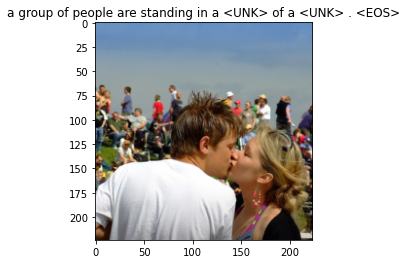

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


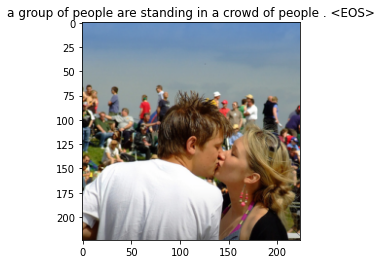

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


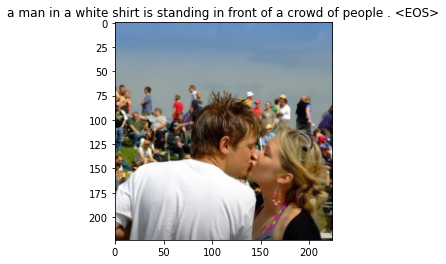

In [6]:
plt.figure(figsize=(4, 4))
show_image(image1, caption1)
show_image(image2, caption2)
show_image(image3, caption3)

We can indeed see a clear improvement in the captioning of this image!

## Feeding the model other images from the test dataset

First we have to load the dataset.

In [7]:
config_viz = dict(
    # Paths
    DATA_LOCATION=DATA_LOCATION,

    # Training data
    batch_size=50,
    train_size=0.8,
)

In [8]:
dataset = make_dataset_notebook(config_viz)

In [9]:
vocab = dataset.vocab

In [10]:
train_loader, test_loader = make_dataloaders_notebook(config_viz, dataset, 1)

In [11]:
model.decoder.device = device

Now we can show the images with the predicted captions and the real captions.

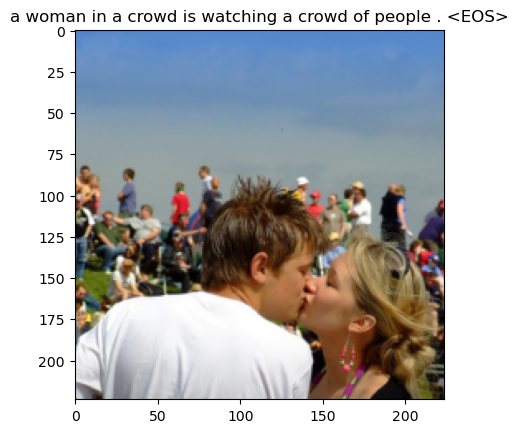

In [8]:
model.eval()
with torch.no_grad():
    dataiter = iter(test_loader)
    img,_ = next(dataiter)
    features = model.encoder(img[0:1].to(device))
    caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
    caption = ' '.join(caps)
    show_image(img[0],title=caption)

In [ ]:
# Number of images to show
num_show = 3

# Showing the images
test_loader_showing = deepcopy(test_loader)
with torch.no_grad():
    dataiter = iter(test_loader_showing)
    for i in range(num_show):    
        img, real_captions = next(dataiter)
        features = model.encoder(img[0:1].to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(img[0],title=caption)
        print("REAL CAPTIONS:\n")
        for i in range(len(real_captions)):
            print(dataset.vocab.get_caption(real_captions[i].tolist()))

In [9]:
text_to_speech('a man in a white shirt is standing in front of a crowd of people.', 'cpu')

## Feeding the model a custom image

In [11]:
# Path to the custom image
img_location = DATA_LOCATION + '/Custom/us3.png' 

# Transforming the image to the correct format
img = Image.open(img_location)
img = img.convert("RGB")
img = transforms(img)
img = img.unsqueeze(0)

FileNotFoundError: [Errno 2] No such file or directory: '../data/Custom/us3.png'

In [ ]:
# Feeding the model the image
features = model.encoder(img.to(device))
caps, alphas = model.decoder.generate_caption(features, vocab=vocab)

# Showing the caption and the image
caption = ' '.join(caps)
show_image(img[0], caption)

## Visualizing the attention for a certain image

In [ ]:
test_loader_showing = deepcopy(test_loader)
dataiter = iter(test_loader_showing)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(model, img.unsqueeze(0), vocab, device)

plot_attention(img1, caps, alphas)

## Seeing the output of the Encoder for an image

In [ ]:
# Getting an image from the raw dataset
path = DATA_LOCATION + "/Images" 
files = [f for f in os.listdir(path) if f.endswith('.jpg')]
file= files[2]
img = Image.open(os.path.join(path, file))

In [ ]:
# Transforming the image to the correct format
img = img.convert("RGB")
img = transforms(img)
img = img.unsqueeze(0)

In [ ]:
# Passing the image through the encoder
features = model.encoder(img.to(device))

In [ ]:
features.shape

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(features[0], cmap='gist_stern', aspect='auto')  # Display the tensor as an image
plt.colorbar()
plt.title("Features after Encoder")
plt.show()

## Seeing how the embedding works inside the Decoder

In [ ]:
# Visualizing the captions for the 3rd image in the train dataset
i = 2
captions = list(dataset.captions[0 + i*5 : 5 + i*5])
captions

In [ ]:
# Getting the processed captions for the 3rd image in the train dataset
test_train_loader = deepcopy(train_loader)
_, caption = next(iter(train_loader))
captions = [caption[i] for i in range(10,15)]
captions = torch.stack(captions); captions

In [ ]:
# Generating an intance of the embedding class from torch
vocab_size = len(dataset.vocab)
embed_size = 300
embdedding = nn.Embedding(vocab_size, embed_size)

In [ ]:
# Embedding the 5 captions
embedded = embdedding(captions)

In [ ]:
# First caption embedded
embedded[0]

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(embedded[0].detach().numpy(), cmap='gnuplot2', aspect='auto')  # Display the tensor as an image
plt.colorbar()
plt.title("Caption embedded")
plt.ylabel("Caption dimension")
plt.xlabel("Embedding dimension $R^{300}$")
plt.show()
print("Caption embedded:", captions[0])

## Visualizing the attention weights for a certain caption

In [ ]:
caps, alphas = model.decoder.generate_caption(features, vocab=vocab)

In [ ]:
alpha = torch.tensor(alphas[0])

In [ ]:
alpha.shape # the first dimension is the number of words of the caption

In [ ]:
alpha_values = np.array(alpha[0].tolist())
matrix = alpha_values.reshape((7, 7))
plt.imshow(matrix, cmap='viridis')  # You can choose a different colormap if desired
plt.colorbar()
plt.title('Alpha scores (attention)')
plt.show()

In [ ]:
features.shape

In [ ]:
attention_weights = features * alpha.unsqueeze(2)
attention_weights = attention_weights.sum(dim=1)

In [ ]:
len(attention_weights[0])

In [ ]:
attention_weights

In [ ]:
plt.figure(figsize=(15,4))
plt.bar(range(len(features.sum(dim=1)[0])), features.sum(dim=1)[0], color='green')
plt.title('Features vector (before being weighted by alpha scores)') # Dictates where to focus the attention
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
plt.bar(range(len(attention_weights[0])), attention_weights[0], color='red')
plt.title('Context vector (weighted features)') # Dictates where to focus the attention
plt.show()